In [1]:
import json
import random
import numpy as np
import pandas as pd

In [2]:
import json
import pandas as pd
from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines
from utils.simple_priority_heuristics import schedule_spt
from utils.checker import check_machine_conflicts
from utils.checker import check_job_machine_sequence
from utils.checker import check_job_machine_sequence_dict
from utils.checker import check_correct_start
from utils.scheduler import generate_job_arrivals
from utils.scheduler import solve_jobshop_optimal
from utils.scheduler import solve_stage2_early_starts
import utils.editor as edit

In [3]:
def print_jobs_compact(job_dict):
    for job, tasks in job_dict.items():
        print(f"{job}:\t{tasks}")

In [4]:
# Datei laden
with open("data/jobshop_instances_named.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]

In [5]:
job_set_list = []

# Alle Jobs sortieren
sorted_job_names = sorted(instance, key=lambda x: int(x.split()[1]))

# Erzeuge 4 vollständige Varianten der Instanz mit umbenannten Jobs
for variant in range(4):
    job_dict = {}
    for original_index, job_name in enumerate(sorted_job_names):
        new_name = f"Job {variant:02d}_{original_index}"  # z. B. job 00_0, job 01_4, ...
        job_dict[new_name] = instance[job_name]
    job_set_list.append(job_dict)

# Ausgabe (erste 2)
for idx, job_set in list(enumerate(job_set_list))[:2]:
    print(f"\n--- Jobset {idx} ---")
    print_jobs_compact(job_set)


--- Jobset 0 ---
Job 00_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 00_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 00_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 00_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 00_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 00_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 00_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 00_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 00_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 00_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 5

## I) Day 0

In [7]:
this_day_jobs = job_set_list[0]
print_jobs_compact(this_day_jobs)

Job 00_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 00_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 00_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 00_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 00_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 00_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 00_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 00_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 00_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 00_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

### a) Ankunftszeiten

In [9]:
df_arrivals = generate_job_arrivals(this_day_jobs, u_b_mmax=0.9, day_id=0)
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 00_5,0,83.59
1,Job 00_8,0,107.22
2,Job 00_7,0,125.26
3,Job 00_0,0,181.45
4,Job 00_4,0,270.56
5,Job 00_9,0,309.13
6,Job 00_3,0,586.13
7,Job 00_2,0,667.09
8,Job 00_1,0,713.06
9,Job 00_6,0,747.96


### b) Scheduling - HiGHS

In [11]:
df_schedule_highs, opt_makespan = solve_jobshop_optimal(this_day_jobs, df_arrivals)
print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")
df_schedule_highs

Optimaler Makespan: 1346.37 Zeiteinheiten


,Job,Machine,Day-ID,Start,Duration,End
0,Job 00_0,M0,0,410.68,29,439.68
1,Job 00_0,M1,0,443.74,78,521.74
2,Job 00_0,M2,0,662.62,9,671.62
3,Job 00_0,M3,0,717.68,36,753.68
4,Job 00_0,M4,0,807.68,49,856.68
...,...,...,...,...,...,...
95,Job 00_9,M9,0,542.62,76,618.62
96,Job 00_9,M5,0,618.62,47,665.62
97,Job 00_9,M3,0,665.62,52,717.62
98,Job 00_9,M4,0,717.62,90,807.62


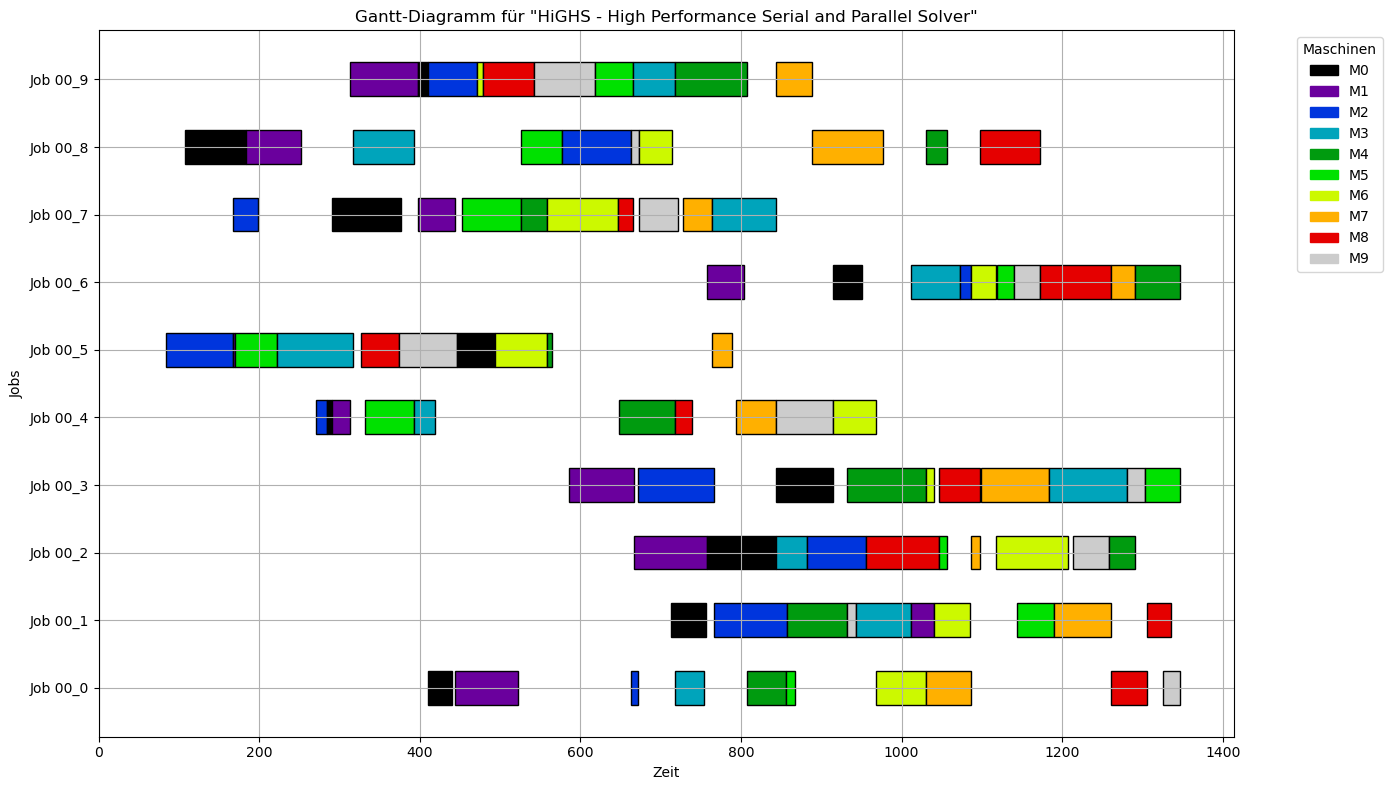

Keine Maschinenkonflikte gefunden.

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0

Alle Starts erfolgen nach der Ankunftszeit.


In [12]:
# Plot
category = "HiGHS - High Performance Serial and Parallel Solver"
plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

# Check
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence_dict(df_schedule_highs, this_day_jobs)
check_correct_start(df_schedule_highs, df_arrivals)

### c) Tageslimit (z.B. 21 Stunden)

In [14]:
df_late = edit.get_operations_ending_after_day_limit(df_schedule_highs, 21)
df_late

,Job,Machine,Day-ID,Start,Duration,End
8,Job 00_0,M8,0,1261.43,44,1305.43
9,Job 00_0,M9,0,1325.37,21,1346.37
18,Job 00_1,M7,0,1189.31,72,1261.31
19,Job 00_1,M8,0,1305.49,30,1335.49
29,Job 00_2,M4,0,1258.31,33,1291.31
37,Job 00_3,M3,0,1183.37,98,1281.37
38,Job 00_3,M9,0,1281.37,22,1303.37
39,Job 00_3,M5,0,1303.37,43,1346.37
67,Job 00_6,M8,0,1172.37,89,1261.37
68,Job 00_6,M7,0,1261.37,30,1291.37


In [15]:
remaining_jobs = edit.get_jssp_from_schedule(df_late)
print_jobs_compact(remaining_jobs)

Job 00_0:	[[8, 44], [9, 21]]
Job 00_1:	[[7, 72], [8, 30]]
Job 00_2:	[[4, 33]]
Job 00_3:	[[3, 98], [9, 22], [5, 43]]
Job 00_6:	[[8, 89], [7, 30], [4, 55]]


## II) Day 1

In [17]:
this_day_jobs = job_set_list[1]
print_jobs_compact(this_day_jobs)

Job 01_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 01_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 01_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 01_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 01_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 01_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 01_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 01_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 01_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 01_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

### Zwischenankuftszeiten der neuen Jobs

In [19]:
df_arrivals = generate_job_arrivals(this_day_jobs, day_id = 1)
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 01_5,1,83.59
1,Job 01_8,1,107.22
2,Job 01_7,1,125.26
3,Job 01_0,1,181.45
4,Job 01_4,1,270.56
5,Job 01_9,1,309.13
6,Job 01_3,1,586.13
7,Job 01_2,1,667.09
8,Job 01_1,1,713.06
9,Job 01_6,1,747.96


### Zwischenankuftszeiten der alten Jobs ergänzen

In [21]:
df_arrivals = edit.add_remaining_jobs_with_zero_arrival(df_arrivals, remaining_jobs, day_id=1)
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 00_0,1,0.00
1,Job 00_1,1,0.00
2,Job 00_2,1,0.00
3,Job 00_3,1,0.00
4,Job 00_6,1,0.00
5,Job 01_5,1,83.59
6,Job 01_8,1,107.22
7,Job 01_7,1,125.26
8,Job 01_0,1,181.45
9,Job 01_4,1,270.56


### Merge: Job-PseudoMatrix aller Jobs (alte + neue)

In [23]:
this_day_jobs_extended = edit.merge_jobs(remaining_jobs, this_day_jobs)
print_jobs_compact(this_day_jobs_extended)

Job 00_0:	[[8, 44], [9, 21]]
Job 00_1:	[[7, 72], [8, 30]]
Job 00_2:	[[4, 33]]
Job 00_3:	[[3, 98], [9, 22], [5, 43]]
Job 00_6:	[[8, 89], [7, 30], [4, 55]]
Job 01_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 01_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 01_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 01_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 01_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 01_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 01_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 01_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 01_8:	[[0, 76], [1, 69], [3, 76], [5, 5

### Scheduling

In [25]:
df_schedule_highs, opt_makespan = solve_jobshop_optimal(this_day_jobs_extended, df_arrivals, day_id = 1)
print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")

Optimaler Makespan: 1346.25 Zeiteinheiten


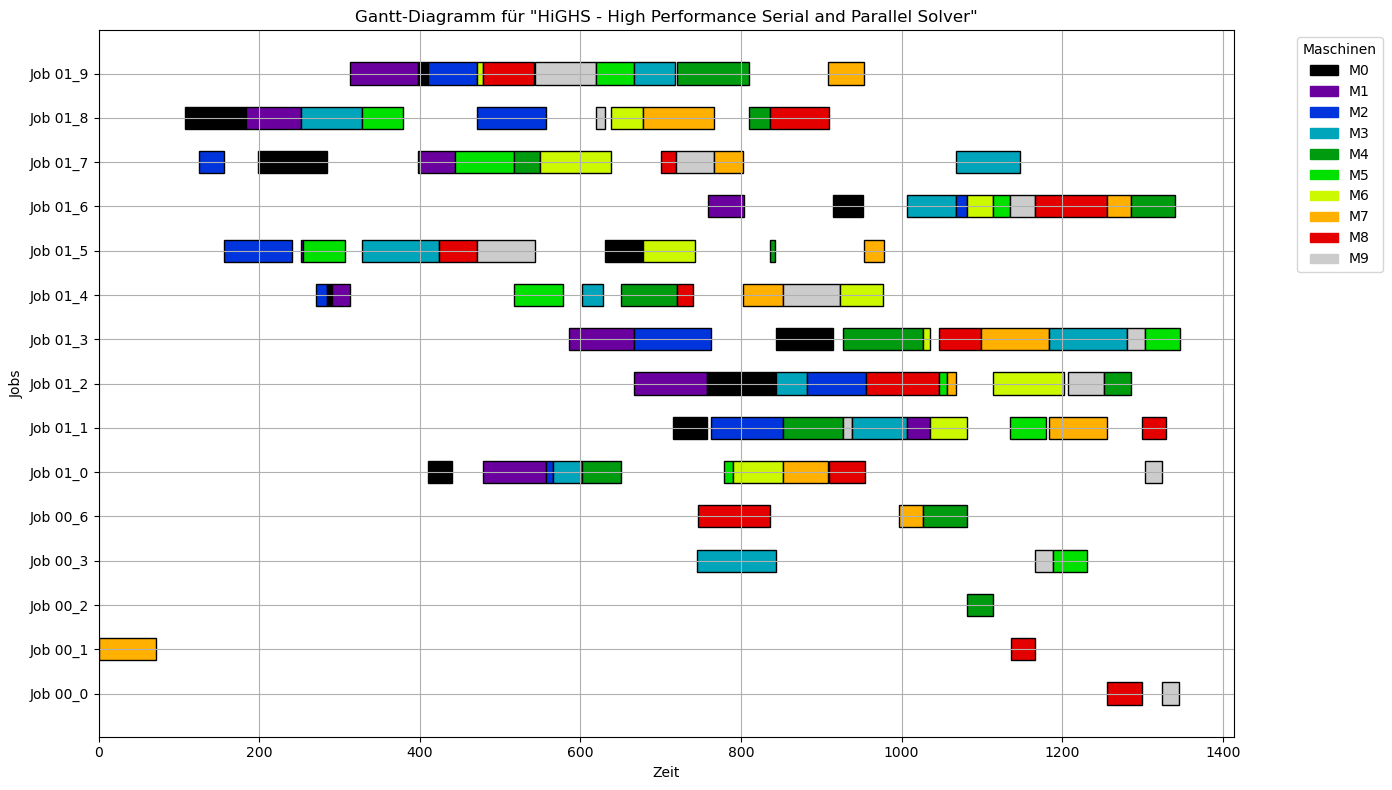

Keine Maschinenkonflikte gefunden.

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0

Alle Starts erfolgen nach der Ankunftszeit.


In [26]:
# Plot 
category = "HiGHS - High Performance Serial and Parallel Solver"
plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

# Check
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence_dict(df_schedule_highs, this_day_jobs_extended)
check_correct_start(df_schedule_highs, df_arrivals)

### Tageslimit

In [28]:
df_late = edit.get_operations_ending_after_day_limit(df_schedule_highs, 21)
remaining_jobs = edit.get_jssp_from_schedule(df_late)
print_jobs_compact(remaining_jobs)

Job 00_0:	[[8, 44], [9, 21]]
Job 01_0:	[[9, 21]]
Job 01_1:	[[8, 30]]
Job 01_2:	[[4, 33]]
Job 01_3:	[[3, 98], [9, 22], [5, 43]]
Job 01_6:	[[7, 30], [4, 55]]


## III) Day 2

In [30]:
day_jobs = job_set_list[2]

# Ankunftszeiten der neuen Jobs 
df_arrivals = generate_job_arrivals(day_jobs, day_id = 2)

# Job-PseudoMatrix aller Jobs (alte + neue)
day_jobs_extended = edit.merge_jobs(remaining_jobs, day_jobs)

# Ankunftszeiten der alten Jobs werden angehängt (mit Zwischenankunftszeit 0)
df_arrivals = edit.add_remaining_jobs_with_zero_arrival(df_arrivals, remaining_jobs, day_id=2)

### Scheduling

In [32]:
df_schedule_highs, opt_makespan = solve_jobshop_optimal(day_jobs_extended, df_arrivals, day_id = 2)
print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")

Optimaler Makespan: 1346.25 Zeiteinheiten


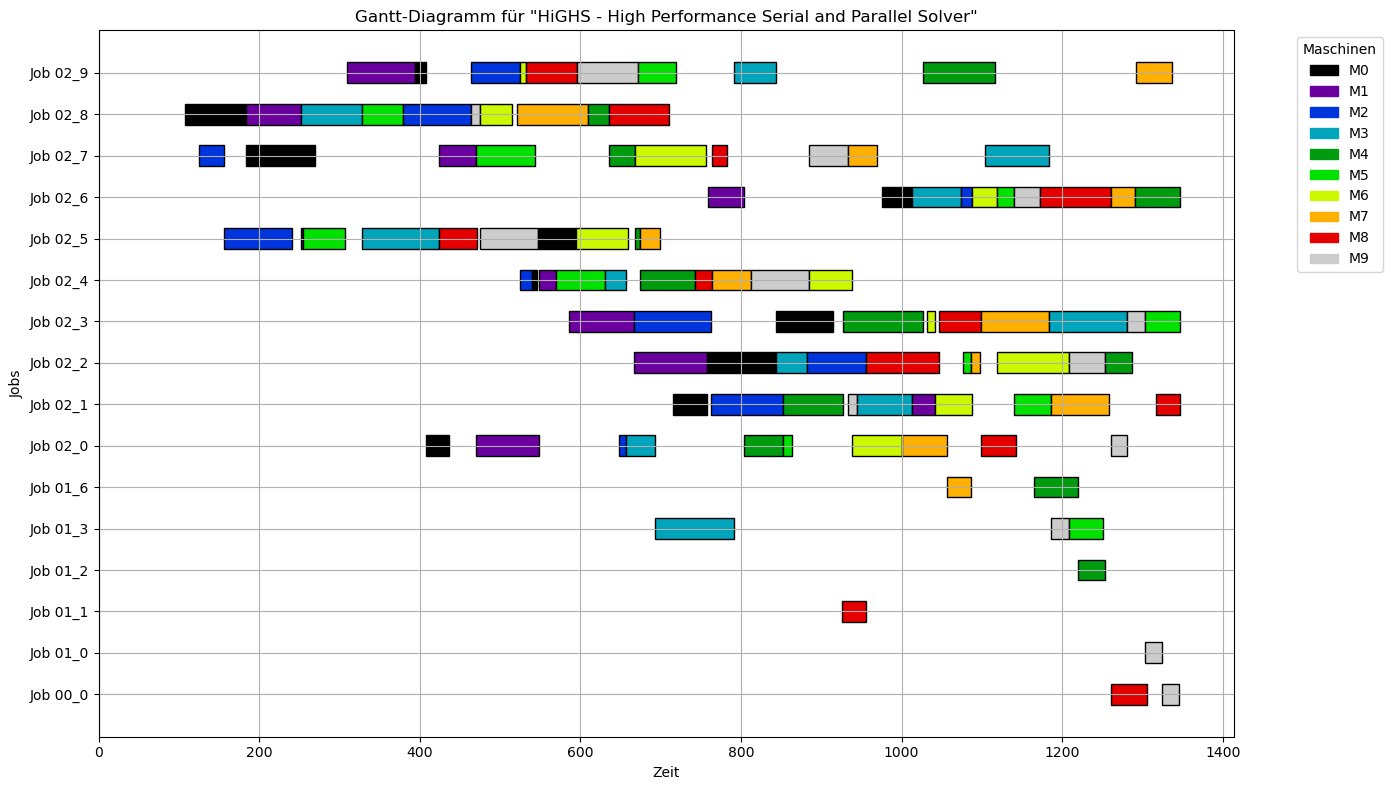

Keine Maschinenkonflikte gefunden.

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0

Alle Starts erfolgen nach der Ankunftszeit.


In [33]:
# Plot 
category = "HiGHS - High Performance Serial and Parallel Solver"
plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

# Check
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence_dict(df_schedule_highs, day_jobs_extended)
check_correct_start(df_schedule_highs, df_arrivals)

> Problem: Operationen des Jobs 00_0 sind wieder ganz am Ende --> werden wieder auf nächsten Tag gelegt

### <font color="darkgreen"> Scheduling - Stage 2 </font>

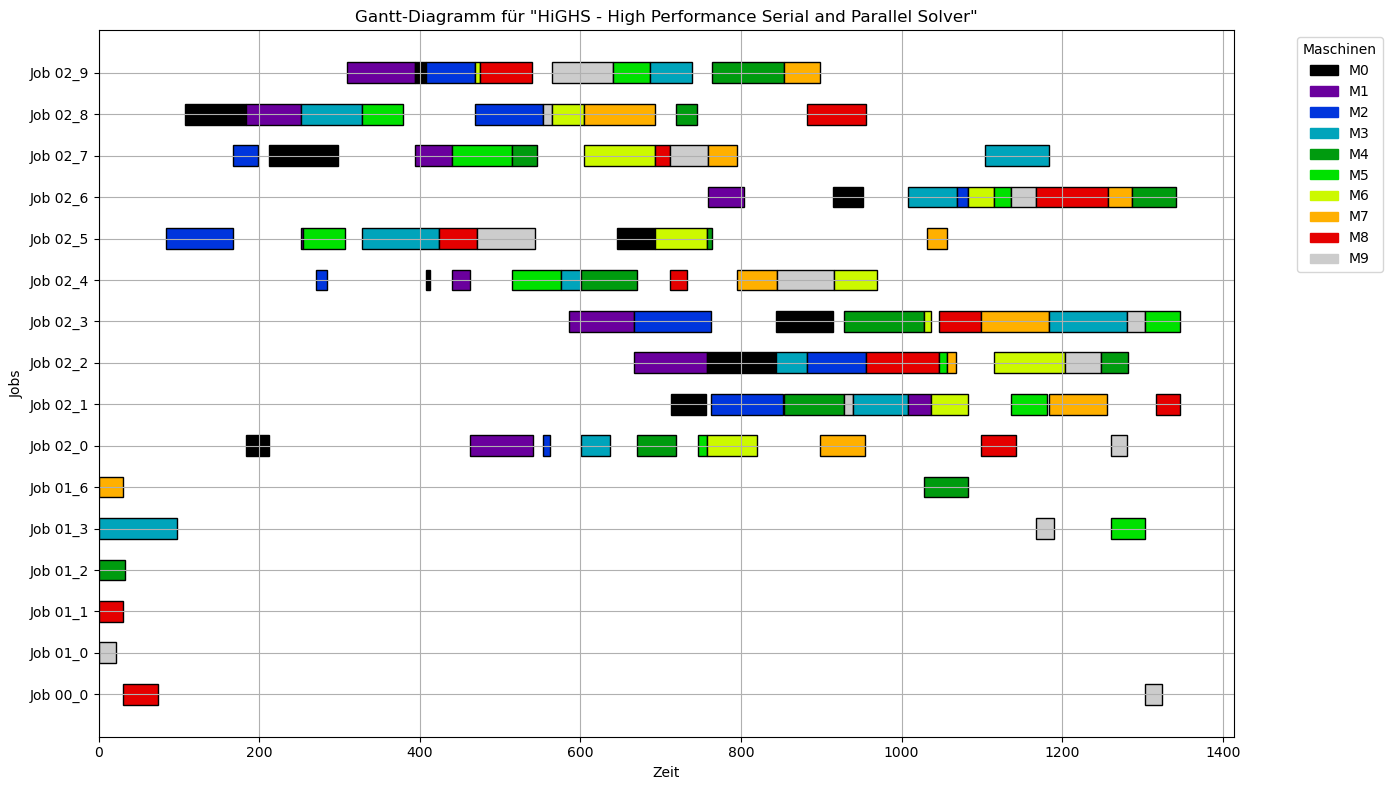

Keine Maschinenkonflikte gefunden.

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0

Alle Starts erfolgen nach der Ankunftszeit.


In [36]:
df_schedule_early_starts, makespan = solve_stage2_early_starts(day_jobs_extended, df_arrivals, opt_makespan, day_id = 2)

# Plot
category = "HiGHS - High Performance Serial and Parallel Solver"
dframe_schedule = df_schedule_early_starts
plot_gantt_jobs(dframe_schedule, 'Gantt-Diagramm für "{}"'.format(category))

# Check
check_machine_conflicts(dframe_schedule)
check_job_machine_sequence_dict(dframe_schedule, day_jobs_extended)
check_correct_start(dframe_schedule, df_arrivals)

### Tageslimit

In [38]:
df_late = edit.get_operations_ending_after_day_limit(df_schedule_early_starts, 21)
remaining_jobs = edit.get_jssp_from_schedule(df_late)
print_jobs_compact(remaining_jobs)

Job 00_0:	[[9, 21]]
Job 01_3:	[[5, 43]]
Job 02_0:	[[9, 21]]
Job 02_1:	[[8, 30]]
Job 02_2:	[[4, 33]]
Job 02_3:	[[3, 98], [9, 22], [5, 43]]
Job 02_6:	[[7, 30], [4, 55]]


## IV) Day 3

In [40]:
day_jobs = job_set_list[3]

# Ankunftszeiten der neuen Jobs 
df_arrivals = generate_job_arrivals(day_jobs, day_id = 3)

# Job-PseudoMatrix aller Jobs (alte + neue)
day_jobs_extended = edit.merge_jobs(remaining_jobs, day_jobs)

# Ankunftszeiten der alten Jobs werden angehängt (mit Zwischenankunftszeit 0)
df_arrivals = edit.add_remaining_jobs_with_zero_arrival(df_arrivals, remaining_jobs, day_id=3)

Optimaler Makespan: 1346.37 Zeiteinheiten


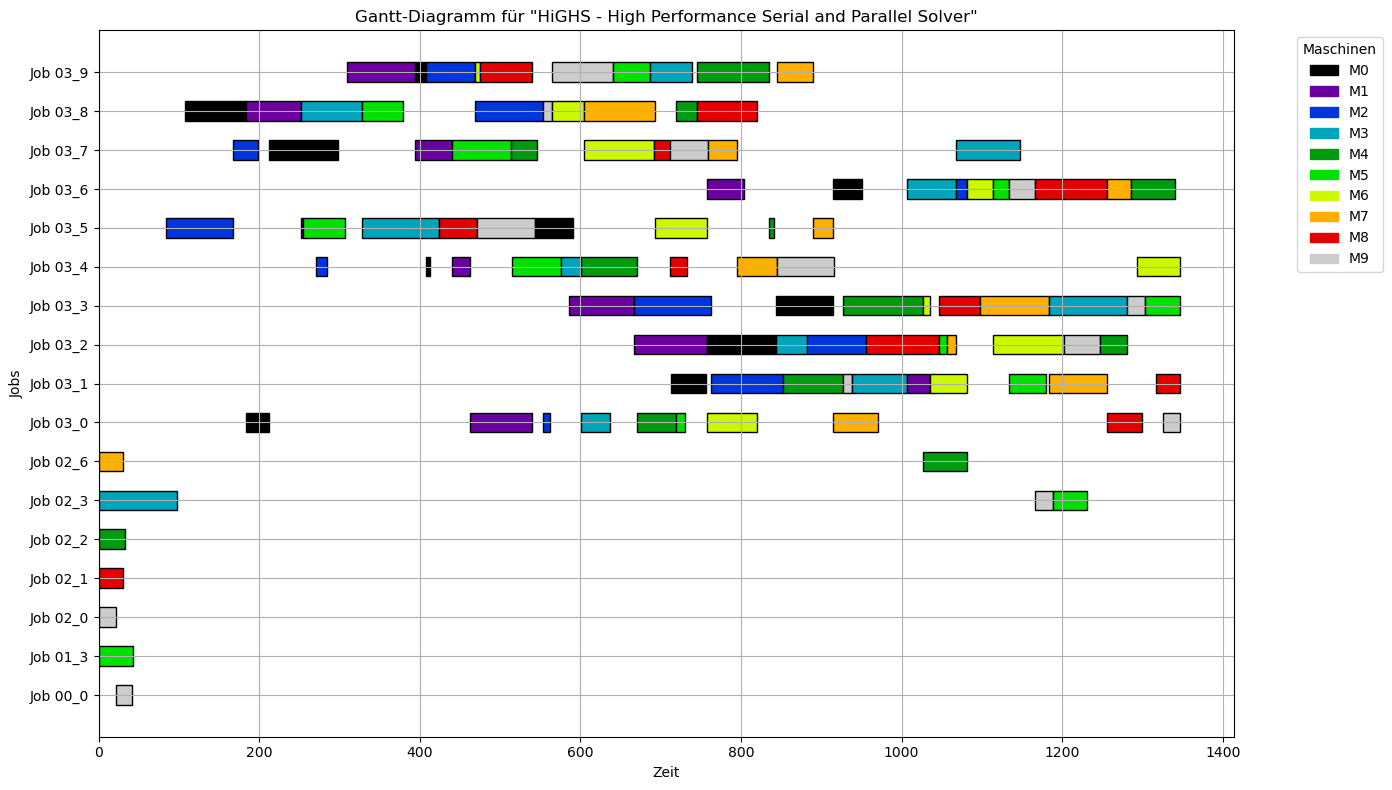

Keine Maschinenkonflikte gefunden.

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0

Alle Starts erfolgen nach der Ankunftszeit.


In [41]:
# Solve
df_schedule_highs, opt_makespan = solve_jobshop_optimal(day_jobs_extended, df_arrivals, day_id = 3, solver_time_limit=1000)
df_schedule_early_starts, makespan = solve_stage2_early_starts(day_jobs_extended, df_arrivals, opt_makespan, day_id = 3)
df_schedule_early_starts

print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")

# Plot 
category = "HiGHS - High Performance Serial and Parallel Solver"
dframe_schedule = df_schedule_early_starts
plot_gantt_jobs(dframe_schedule, 'Gantt-Diagramm für "{}"'.format(category))

# Check
check_machine_conflicts(dframe_schedule)
check_job_machine_sequence_dict(dframe_schedule, day_jobs_extended)
check_correct_start(dframe_schedule, df_arrivals)